In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style

import tqdm
from torch.optim import Adam

In [3]:
class GaussianFourierProjection(nn.Module):
    def __init__(self, embed_dim, scale=30.):
        super().__init__()
    # Randomly sample weights during initialization. These weights are fixed 
    # during optimization and are not trainable.
        self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
    
    def forward(self, x):
        x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
        
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

In [4]:
class Dense(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.dense = nn.Linear(input_dim, output_dim)
        
    def forward(self, x):
        return self.dense(x)[..., None]

In [5]:
class ScoreNet_U(nn.Module):
    def __init__(self, shape1, shape2, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256):
        super().__init__()
        
        self.xlayer1 = nn.Linear(shape1, shape2)
        self.xlayer2 = nn.Linear(shape2, shape1)
        
        # Gaussian random feature embedding layer for time
        self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
         nn.Linear(embed_dim, embed_dim))
    # Encoding layers where the resolution decreases
        self.conv1 = nn.Conv1d(1, channels[0], 3, stride=1, bias=False)
        self.dense1 = Dense(embed_dim, channels[0])
        self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])
        self.conv2 = nn.Conv1d(channels[0], channels[1], 3, stride=2, bias=False)
        self.dense2 = Dense(embed_dim, channels[1])
        self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])
        self.conv3 = nn.Conv1d(channels[1], channels[2], 3, stride=2, bias=False)
        self.dense3 = Dense(embed_dim, channels[2])
        self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
        self.conv4 = nn.Conv1d(channels[2], channels[3], 3, stride=2, bias=False)
        self.dense4 = Dense(embed_dim, channels[3])
        self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])    

    # Decoding layers where the resolution increases
        self.tconv4 = nn.ConvTranspose1d(channels[3], channels[2], 3, stride=2, bias=False)
        self.dense5 = Dense(embed_dim, channels[2])
        self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])
        self.tconv3 = nn.ConvTranspose1d(channels[2] + channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)    
        self.dense6 = Dense(embed_dim, channels[1])
        self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
        self.tconv2 = nn.ConvTranspose1d(channels[1] + channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)    
        self.dense7 = Dense(embed_dim, channels[0])
        self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
        self.tconv1 = nn.ConvTranspose1d(channels[0] + channels[0], 1, 3, stride=1)
    
    # The swish activation function
        self.act = lambda x: x * torch.sigmoid(x)
        self.marginal_prob_std = marginal_prob_std
    def forward(self, x, t): 
    # Obtain the Gaussian random feature embedding for t   
        embed = self.act(self.embed(t))    
    # Encoding path
        x = self.xlayer1(x)
        h1 = self.conv1(x)    
        ## Incorporate information from t
        h1 += self.dense1(embed)
        ## Group normalization
        h1 = self.gnorm1(h1)
        h1 = self.act(h1)
        h2 = self.conv2(h1)
        h2 += self.dense2(embed)
        h2 = self.gnorm2(h2)
        h2 = self.act(h2)
        h3 = self.conv3(h2)
        h3 += self.dense3(embed)
        h3 = self.gnorm3(h3)
        h3 = self.act(h3)
        h4 = self.conv4(h3)
        h4 += self.dense4(embed)
        h4 = self.gnorm4(h4)
        h4 = self.act(h4)

    # Decoding path
        h = self.tconv4(h4)
        ## Skip connection from the encoding path
        h += self.dense5(embed)
        h = self.tgnorm4(h)
        h = self.act(h)
        h = self.tconv3(torch.cat([h, h3], dim=1))
        h += self.dense6(embed)
        h = self.tgnorm3(h)
        h = self.act(h)
        h = self.tconv2(torch.cat([h, h2], dim=1))
        h += self.dense7(embed)
        h = self.tgnorm2(h)
        h = self.act(h)
        h = self.tconv1(torch.cat([h, h1], dim=1))

        h = self.xlayer2(h)
    # Normalize output
        h = h / self.marginal_prob_std(t)[:, None, None]
        return h

In [6]:
device = 'cuda'

In [7]:
def marginal_prob_std(t, sigma):
    
    t = torch.tensor(t, device = device)
    
    return torch.sqrt((sigma ** (2*t)-1) / (2 * np.log(sigma)))

In [8]:
def diffusion_coeff(t, sigma):
    return torch.tensor(sigma**t, device = device)

In [9]:
s =  100 #should be large enough

marginal_prob_std_fn = lambda t: marginal_prob_std(t, sigma=s)
diffusion_coeff_fn = lambda t: diffusion_coeff(t, sigma=s)

In [10]:
def loss_fn(model, x, marginal_prob_std, eps=1e-5):
    random_t = torch.rand(x.shape[0], device = device) * (1. - eps) + eps  
    z = torch.randn_like(x)
    std = marginal_prob_std(random_t)
    perturbed_x = x + z * std[:, None, None]
    score = model(perturbed_x, random_t)
    loss = torch.mean(torch.sum((score * std[:, None, None] + z)**2, dim=(1,2)))
    return loss

In [12]:
x1 = -30
x2 = 0
x3 = 30
y1 = torch.randn(10000,1,1) + x1
y2 = torch.randn(10000,1,1) + x2
y3 = torch.randn(10000,1,1) + x3
y = torch.cat([y1,y2,y3],dim=0)
idx = torch.randperm(y.nelement())
y_train = y.view(-1)[idx].view(y.size())
y_train = y_train.reshape((60,500,1,1))
y_train = y_train.cuda()

In [13]:
score_model= ScoreNet_U(shape1=y_train[0].shape[2], shape2=20,marginal_prob_std=marginal_prob_std_fn)
score_model = score_model.cuda()

In [18]:
lr = 1e-4
optimizer = Adam(score_model.parameters(), lr=lr)

n_epochs = 5000
tqdm_epoch = tqdm.notebook.trange(n_epochs)
loss_list = []

epoch_number = 0
best_loss = 1000000

for epoch in tqdm_epoch:
    loss_train = 0
    epoch_numeber = 0.
    
    for xt in y_train:
        loss = loss_fn(model=score_model, x=xt, marginal_prob_std=marginal_prob_std_fn)
        loss_train += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if epoch_number  % 5 ==0:
        print('epoch_number: {}, current_loss: {}, best_loss: {}'.format(epoch_number, loss_train, best_loss))
        
    if loss_train/(y_train.shape[0]*y_train.shape[1]) < best_loss:
        best_loss = loss_train/(y_train.shape[0]*y_train.shape[1])
        model_path = 'uncon_mix\\model_{}.pth'.format(epoch_number)
        torch.save(score_model.state_dict(), model_path)
        
    loss_list.append(loss_train)
    epoch_number += 1

  0%|          | 0/5000 [00:00<?, ?it/s]

C:\Users\dedaoyan\AppData\Local\Temp\ipykernel_2236\1117097296.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device = device)


epoch_number: 0, current_loss: 54.85790181159973, best_loss: 1000000
epoch_number: 5, current_loss: 51.354078233242035, best_loss: 0.0017235470175743102
epoch_number: 10, current_loss: 44.48122721910477, best_loss: 0.001540889290968577
epoch_number: 15, current_loss: 37.558658838272095, best_loss: 0.0012507266521453858
epoch_number: 20, current_loss: 34.2530420422554, best_loss: 0.0011668344308932623
epoch_number: 25, current_loss: 32.25313365459442, best_loss: 0.0010962600817282994
epoch_number: 30, current_loss: 32.92783519625664, best_loss: 0.0010751044551531473
epoch_number: 35, current_loss: 30.83446842432022, best_loss: 0.001049091425538063
epoch_number: 40, current_loss: 31.112188905477524, best_loss: 0.0010278156141440074
epoch_number: 45, current_loss: 30.45639231801033, best_loss: 0.0010278156141440074
epoch_number: 50, current_loss: 30.21857750415802, best_loss: 0.0010105034023523331
epoch_number: 55, current_loss: 31.382796108722687, best_loss: 0.000999908909201622
epoch_nu

In [14]:
score_model.load_state_dict(torch.load('uncon_mix\\model_3696.pth'))

<All keys matched successfully>

In [15]:
def Euler_Maruyama_sampler(score_model, batch_size, marginal_prob_std, diffusion_coeff, num_steps, eps=1e-3):
    t = torch.ones(batch_size)
    init_x = torch.randn((batch_size, 1, 1),device=device)  * marginal_prob_std(t)[:, None, None]
    time_steps = torch.linspace(1., eps, num_steps)
    step_size = time_steps[0] - time_steps[1]
    x = init_x
    with torch.no_grad():
        for time_step in tqdm.notebook.tqdm(time_steps):      
            batch_time_step = torch.ones(batch_size, device=device) * time_step
            g = diffusion_coeff(batch_time_step)
            mean_x = x + (g**2)[:, None, None] * score_model(x, batch_time_step) * step_size
            x = mean_x + torch.sqrt(step_size) * g[:, None, None] * torch.randn_like(x)      
  # Do not include any noise in the last sampling step.
    
    return mean_x

In [16]:
def Predictor_Corrector_sampler(score_model, batch_size, marginal_prob_std, diffusion_coeff, num_steps, eplsion=1e-2, eps=1e-3):
    t = torch.ones(batch_size, device = device)
    init_x = torch.randn(batch_size, 1, 1, device = device) * marginal_prob_std(t)[:, None, None]
    time_steps = torch.linspace(1., eps, num_steps)
    step_size = time_steps[0] - time_steps[1]
    x = init_x
    with torch.no_grad():
        for time_step in tqdm.notebook.tqdm(time_steps):      
            batch_time_step = torch.ones(batch_size, device = device) * time_step
            score = score_model(x, batch_time_step)
            
            #MCMC step:
            for i in range(1):
                x = x + eplsion * score + torch.sqrt(2*torch.tensor(eplsion)) * torch.randn_like(x)
                
            #EM step
            g = diffusion_coeff(batch_time_step)
            mean_x = x + (g**2)[:, None, None] * score * step_size
            x = mean_x + torch.sqrt(step_size) * g[:, None, None] * torch.randn_like(x)      
  # Do not include any noise in the last sampling step.
    
    return mean_x

In [26]:
x_mix_em = Euler_Maruyama_sampler(score_model, 500, marginal_prob_std_fn, diffusion_coeff_fn, num_steps=10000, eps=1e-3)

C:\Users\dedaoyan\AppData\Local\Temp\ipykernel_9280\1117097296.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device = device)


  0%|          | 0/10000 [00:00<?, ?it/s]

C:\Users\dedaoyan\AppData\Local\Temp\ipykernel_9280\4062452966.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device = device)


In [27]:
x_mix_em_data = torch.reshape(x_mix_em,(500,1)).cpu().numpy()

In [28]:
x_mix_em_data = torch.reshape(x_mix_em.repeat(60,1,1,1),(500*60,1)).cpu().numpy()

In [29]:
x_mix_pc= Predictor_Corrector_sampler(score_model, 500, marginal_prob_std_fn, diffusion_coeff_fn, 10000, eplsion=1e-2, eps=1e-3)

C:\Users\dedaoyan\AppData\Local\Temp\ipykernel_9280\1117097296.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device = device)


  0%|          | 0/10000 [00:00<?, ?it/s]

C:\Users\dedaoyan\AppData\Local\Temp\ipykernel_9280\4062452966.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device = device)


In [30]:
x_mix_pc_data = torch.reshape(x_mix_pc.repeat(60,1,1,1),(500*60,1)).cpu().numpy()

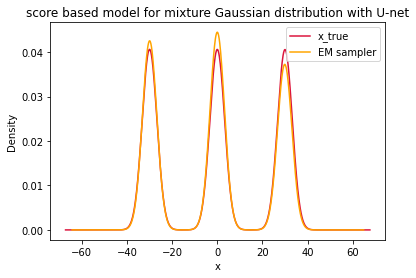

In [31]:
df1 = pd.DataFrame({'x_true': y_train.reshape(500*60).cpu().numpy()})
df1['EM sampler'] = x_mix_em_data
df1.plot.density(color=['crimson','orange'])
plt.xlabel('x')
plt.title('score based model for mixture Gaussian distribution with U-net')
plt.legend(loc='upper right')

In [32]:
df1.to_csv("C:\\Users\\dedaoyan\\Desktop\\df11.csv", sep='\t')

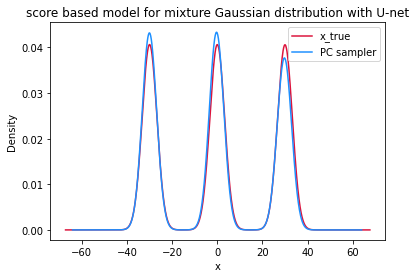

In [33]:
df2 = pd.DataFrame({'x_true': y_train.reshape(500*60).cpu().numpy()})
df2['PC sampler'] = x_mix_pc_data
df2.plot.density(color=['crimson','dodgerblue'])
plt.xlabel('x')
plt.title('score based model for mixture Gaussian distribution with U-net')
plt.legend(loc='upper right')

In [34]:
df2.to_csv("C:\\Users\\dedaoyan\\Desktop\\df22.csv", sep='\t')